In [1]:
from tensorflow.keras.utils import get_file

In [2]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
'babi_tasks_1-20_v1-2.tar.gz')

11747328/11745123 [==============================] - 0s 0us/step


In [3]:
import tarfile, os

with tarfile.open(path) as tar:
  tar.extractall()
  tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [4]:
with open(TRAIN_FILE, 'r') as f:
  for i, line in enumerate(f.readlines()):
    print(line)
    if i > 30:
      break

1 Mary moved to the bathroom.

2 John went to the hallway.

3 Where is Mary? 	bathroom	1

4 Daniel went back to the hallway.

5 Sandra moved to the garden.

6 Where is Daniel? 	hallway	4

7 John moved to the office.

8 Sandra journeyed to the bathroom.

9 Where is Daniel? 	hallway	4

10 Mary moved to the hallway.

11 Daniel travelled to the office.

12 Where is Daniel? 	office	11

13 John went back to the garden.

14 John moved to the bedroom.

15 Where is Sandra? 	bathroom	8

1 Sandra travelled to the office.

2 Sandra went to the bathroom.

3 Where is Sandra? 	bathroom	2

4 Mary went to the bedroom.

5 Daniel moved to the hallway.

6 Where is Sandra? 	bathroom	2

7 John went to the garden.

8 John travelled to the office.

9 Where is Sandra? 	bathroom	2

10 Daniel journeyed to the bedroom.

11 Daniel travelled to the hallway.

12 Where is John? 	office	8

13 John went to the bedroom.

14 John travelled to the office.

15 Where is Daniel? 	hallway	11

1 Mary went to the bedroom.

2 Jo

In [5]:
import pprint 
def read_data(dir):
  stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변
  story_temp = [] # 현재 시점의 스토리 임시 저장 

  with open(dir, 'rb') as lines:
    for line in lines:
      line = line.decode('utf-8') # 'b' 제거
      line = line.strip() # '\n' 제거
      idx, text = line.split(' ', 1) # id number 분리

      if int(idx) == 1:
        story_temp = []

      if '\t' in text: # 질문, \t, 답변 인 경우 
        question, answer, _ = text.split('\t')
        stories.append([x for x in story_temp if x])
        questions.append(question)
        answers.append(answer)
      else: # 현재 읽는 줄이 스토리인 경우 
        story_temp.append(text)
  
  return stories, questions, answers

In [6]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [7]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [8]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [9]:
def print_data(stories, questions, answers, idx):
  pprint.pprint(stories[idx])
  pprint.pprint(questions[idx])
  pprint.pprint(answers[idx])

In [10]:
print_data(train_stories, train_questions, train_answers, 0)

['Mary moved to the bathroom.', 'John went to the hallway.']
'Where is Mary? '
'bathroom'


In [11]:
import re 

def tokenize(sent):
  return [x.strip() for x in re.split('(\w+)', sent) if x.strip()]


In [12]:
import numpy as np
from nltk import FreqDist # 단어 빈도를 인코딩 하는데 사용한다
from functools import reduce # iterable 의 요소들을 function 에 대입하여 결국 하나의 결과값을 리턴하는 함수

def preprocess_data(train_data, test_data):
  counter = FreqDist()

  # 두 문장의 story를 하나의 문장으로 통합하는 함수
  flatten = lambda data: reduce(lambda x, y: x+y, data)

  story_len = []
  question_len = []

  for stories, questions, answers in [train_data, test_data]:
    for story in stories:
      stories = tokenize(flatten(story)) # 스토리의 문장들을 하나로 만든 뒤 토크나이즈
      story_len.append(len(stories))
      for word in stories: # 단어 집합에 단어 추가
        counter[word] += 1
    
    for question in questions:
      question = tokenize(question)
      question_len.append(len(question))
      for word in question:
        counter[word] += 1
    
    for answer in answers:
      answer = tokenize(answer)
      for word in answer:
        counter[word] += 1

  # 단어 집합 생성
  word2idx = {word: (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
  idx2word = {idx: word for word, idx in word2idx.items()}

  # 가장 긴 샘플의 길이
  story_max_len = np.max(story_len)
  question_max_len = np.max(question_len)

  return word2idx, idx2word, story_max_len, question_max_len



In [13]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [14]:
pprint.pprint(word2idx)

{'.': 3,
 '?': 21,
 'Daniel': 7,
 'John': 6,
 'Mary': 8,
 'Sandra': 5,
 'Where': 19,
 'back': 11,
 'bathroom': 12,
 'bedroom': 18,
 'garden': 13,
 'hallway': 14,
 'is': 20,
 'journeyed': 10,
 'kitchen': 17,
 'moved': 15,
 'office': 16,
 'the': 2,
 'to': 1,
 'travelled': 9,
 'went': 4}


In [15]:
vocab_size = len(word2idx) + 1

In [16]:
print('스토리 최대 길이 :', story_max_len)
print('질문의 최대 길이 :', question_max_len)

스토리 최대 길이 : 68
질문의 최대 길이 : 4


In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def vectorize(data, word2idx, story_max_len, question_max_len):
  Xs, Xq, Y = [], [], []
  flatten = lambda data: reduce(lambda x, y: x+y, data)

  stories, questions, answers = data
  for story, question, answer in zip(stories, questions, answers):
    xs = [word2idx[w] for w in tokenize(flatten(story))]
    xq = [word2idx[w] for w in tokenize(question)]

    Xs.append(xs)
    Xq.append(xq)
    Y.append(word2idx[answer])

  return pad_sequences(Xs, maxlen = story_max_len),\
        pad_sequences(Xq, maxlen = question_max_len),\
        to_categorical(Y, num_classes=len(word2idx) + 1)

In [18]:
XsTrain, XqTrain, YTrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
XsTest, XqTest, YTest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [19]:
print(XsTrain.shape, XqTrain.shape, YTrain.shape)
print(XsTest.shape, XqTest.shape, YTest.shape)

(10000, 68) (10000, 4) (10000, 22)
(1000, 68) (1000, 4) (1000, 22)


In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
from tensorflow.keras import layers

In [21]:
train_epoch = 120 
batch_size = 32
embed_size = 50 
lstm_size = 64
dropout_rate = 0.30

In [22]:
input_sequence = layers.Input((story_max_len,))
question = layers.Input((question_max_len,))

print(f"Stories : {input_sequence}")
print(f"Question : {question}")

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question : KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


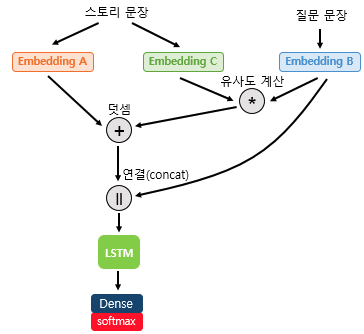

스토리를 위한 첫번째 임베딩. Embedding A    
(samples, story_max_len, embedding_size ) 

In [23]:
story_encoder_a = Sequential()
story_encoder_a.add(layers.Embedding(input_dim=vocab_size, output_dim=embed_size))
story_encoder_a.add(layers.Dropout(dropout_rate))

스토리를 위한 두번째 임베딩. Embedding C     
(samples, story_max_len, question_max_len ) : 임베딩 벡터의 차원을 질문의 최대 길이로 한다

In [24]:
story_encoder_c = Sequential()
story_encoder_c.add(layers.Embedding(input_dim=vocab_size, output_dim=question_max_len))
story_encoder_c.add(layers.Dropout(dropout_rate))

질문을 위한 임베딩. Embedding B
(samples, question_max_len, embedding_size)

In [25]:
question_encoder = Sequential()
question_encoder.add(layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=question_max_len))
question_encoder.add(layers.Dropout(dropout_rate))

임베딩 과정 

In [26]:
story_encoded_a = story_encoder_a(input_sequence)
story_encoded_c = story_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print(f"Story Encoded A - {story_encoded_a}")
print(f"Story Encoded C - {story_encoded_c}")
print(f"Question Encoded - {question_encoded}")


Story Encoded A - KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Story Encoded C - KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question Encoded - KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


내적을 사용해서 스토리 단어들과 질문 단어들 간의 유사도를 구한다.    
(samples, question_max_len, question_max_len)

In [27]:
match = layers.dot([story_encoded_a, question_encoded], axes=-1, normalize=False)
match = layers.Activation('softmax')(match)
print(f"Match Shape - {match}")

Match Shape - KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


구한 유사도와 두번째 스토리 임베딩 벡터를 더한다.

In [28]:
response = layers.add([match, story_encoded_c])
response = layers.Permute((2,1))(response)
print(f"Response Shape - {response}")

Response Shape - KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


더한 결과 벡터를 Question Embed 벡터와 Concatenamte 한다

In [29]:
answer = layers.concatenate([response, question_encoded])
print(f"Answer Shape - {answer}")

Answer Shape - KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [30]:
answer

<KerasTensor: shape=(None, 4, 118) dtype=float32 (created by layer 'concatenate')>

In [31]:
answer = layers.LSTM(lstm_size)(answer)
answer = layers.Dropout(dropout_rate)(answer)
answer = layers.Dense(vocab_size)(answer)
answer = layers.Activation('softmax')(answer)
print(f"Answer Shape - {answer}")

Answer Shape - KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [32]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1100        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4, 50)        1100        input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
history = model.fit([XsTrain, XqTrain],
         YTrain, batch_size, train_epoch,
         validation_data=([XsTest, XqTest], YTest))
# save model
model.save('model.h5')

Epoch 1/120
313/313 [==============================] - 6s 12ms/step - loss: 2.0069 - acc: 0.1625 - val_loss: 1.7904 - val_acc: 0.1800
Epoch 2/120
313/313 [==============================] - 3s 9ms/step - loss: 1.6968 - acc: 0.2484 - val_loss: 1.6673 - val_acc: 0.2350
Epoch 3/120
313/313 [==============================] - 3s 10ms/step - loss: 1.6542 - acc: 0.2673 - val_loss: 1.6330 - val_acc: 0.2680
Epoch 4/120
313/313 [==============================] - 3s 10ms/step - loss: 1.6065 - acc: 0.3403 - val_loss: 1.4742 - val_acc: 0.4010
Epoch 5/120
313/313 [==============================] - 3s 9ms/step - loss: 1.5013 - acc: 0.4008 - val_loss: 1.4700 - val_acc: 0.4060
Epoch 6/120
313/313 [==============================] - 3s 9ms/step - loss: 1.4661 - acc: 0.4205 - val_loss: 1.4817 - val_acc: 0.4050
Epoch 7/120
313/313 [==============================] - 3s 9ms/step - loss: 1.4193 - acc: 0.4485 - val_loss: 1.3570 - val_acc: 0.5040
Epoch 8/120
313/313 [==============================] - 3s 9ms/step

In [33]:
print(f"테스트 정확도 - {model.evaluate([XsTest, XqTest], YTest)[1]}")

In [34]:
yTest = np.argmax(YTest, axis=1)
yTest_ = model.predict([XsTest, XqTest])
yTest2_ = np.argmax(yTest_, axis=1)

In [35]:
print(yTest, yTest_, yTest2_)

[14 12 17 14 17 14 13 14 16 16 17 13 16 18 18 17 13 17 16 17 14 16 16 14
 18 18 18 17 17 17 14 16 17 17 12 16 12 13 17 18 12 13 12 14 13 17 14 12
 16 18 18 16 13 13 17 18 17 14 13 14 14 16 12 13 13 17 17 12 16 16 13 14
 13 18 12 17 17 17 14 16 13 12 18 13 16 13 13 14 17 17 12 12 14 12 12 17
 17 17 18 18 18 12 16 13 13 14 18 12 16 18 12 12 17 14 17 13 16 17 12 16
 18 12 18 14 18 16 13 13 13 12 13 14 12 13 17 12 16 17 12 12 16 14 14 16
 18 17 17 17 17 17 13 13 12 16 18 12 13 18 16 14 18 18 18 13 12 13 13 13
 17 18 16 16 13 12 12 16 17 18 16 16 14 14 14 14 18 12 16 13 17 16 14 17
 13 14 14 13 16 17 12 18 14 16 16 18 14 12 17 14 12 14 12 18 14 18 12 18
 12 14 14 12 12 14 17 14 18 16 14 13 12 12 16 13 14 16 14 18 18 18 18 16
 14 17 13 13 17 17 13 13 13 13 18 16 12 12 18 18 16 16 17 13 13 16 14 16
 16 12 13 18 12 18 17 16 16 17 12 16 17 14 16 12 12 13 16 16 13 16 12 16
 13 12 17 17 18 17 17 13 13 14 14 12 12 12 12 16 14 13 12 16 16 17 13 13
 16 18 13 16 18 16 16 13 13 17 17 13 13 12 18 13 13